In [2]:
from pandas import read_csv
import matplotlib.pyplot as plt #General Plotting
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix


In [3]:
def erm_classifier(X,valid_classes,labels):
    N = len(labels)
    print("Num samples: ", N)

    N_cl = np.array([sum(labels == i) for i in valid_classes])
    print("Num Class Labels: ", N_cl)

    priors = np.array(N_cl/N)
    print("Priors: ", priors)

    C = len(priors)

    # First derive sample-based estimates of mean vector and covariance matrix:
    mu_hat = np.array([np.mean(X[labels == i], axis = 0) for i in valid_classes]) # No labelled samples for 0, 1, 2, 10!

    reg = 0.1*np.identity(X.shape[1]) #7x11

    Sigma_hat = np.array([np.cov(X[labels == i].T) + reg for i in valid_classes]) #7x11x11
    
    # Implement minimum P(error) classification rule on all training samples
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu_hat[c], Sigma_hat[c]) for c in range(len(valid_classes))])
    priors_diag = np.diag(priors)
    class_posteriors = priors_diag.dot(class_cond_likelihoods)

    decisions = np.argmax(class_posteriors, axis = 0) 
    decisions = np.array([i + valid_classes[0] for i in decisions]) # labels start at 3...

    conf_matrix = confusion_matrix(decisions, labels)
    print("Confusion Matrix:\n",conf_matrix)

    errors = len(np.argwhere(decisions != labels))
    print('Number of Misclassifications: ', errors, "\nError Estimate: ", errors/N)

    # Confusion matrix
    conf_mat_b = np.zeros((C, C))

    for i in valid_classes: # Each decision option
        for j in valid_classes: # Each class label
            ind_ij = np.argwhere((decisions==i) & (labels==j))
            conf_mat_b[i, j] = round(len(ind_ij)/N_cl[j],3) # Average over class sample count

            # True label = Marker shape; Decision = Marker Color
            plt.plot(X[ind_ij, 10], X[ind_ij, 6], 'g.', markersize=6)

            if i != j:
                plt.plot(X[ind_ij, 10], X[ind_ij, 6], 'r.', markersize=6)

    print(conf_mat_b)
    plt.title("Correct Classification (Green) and Incorrect Classification (Red) for two features")
    plt.xlabel(r"Label 10")
    plt.ylabel(r"Label 3")
    plt.tight_layout()
    plt.show()

    # Plot for original data and their true labels
    fig = plt.figure(figsize=(10, 10))
    marker_shapes = '.......'
    marker_colors = 'rbgykcm' 

    for i in valid_classes:
        plt.plot(X[labels==i, 10], X[labels==i, 6], marker_shapes[i] + marker_colors[i], label="True Class {}".format(i))

    plt.legend()
    plt.title("True Labels for two features")
    plt.xlabel(r"Label 10")
    plt.ylabel(r"Label 3")
    plt.tight_layout()
    plt.show()

In [4]:
def pca_work(X,valid_classes,labels):
    # Part B - PCA
    # First derive sample-based estimates of mean vector and covariance matrix:
    mu_hat = np.mean(X, axis=0)
    Sigma_hat = np.cov(X.T)

    # Mean-subtraction is a necessary assumption for PCA, so perform this to obtain zero-mean sample set
    C = X - mu_hat
    print(C.shape)

    # Get the eigenvectors (in U) and eigenvalues (in D) of the estimated covariance matrix
    lambdas, U = np.linalg.eig(Sigma_hat)
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]
    # Extract corresponding sorted eigenvectors and eigenvalues
    U = U[:, idx]
    D = np.diag(lambdas[idx])

    # Calculate the PC projections of zero-mean samples (in z)
    Z = C.dot(U)
    print(Z.shape)

    # Let's see what it looks like only along the first two PCs
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(131, projection = '3d')
    ax1.scatter(Z[:, 0], Z[:, 1], Z[:,2])
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.title("PCA projections to 2D space")
    plt.show()


    # Max number of PCs based on rank of X, or min(n, N)
    X_rank = np.linalg.matrix_rank(X)

    rmse = np.zeros(X_rank)
    sum_eigenvals = np.zeros(X_rank)
    no_components = range(1, X_rank + 1)

    # Reconstruct the X data set from each set of projections
    for m in no_components:
        # Reconstruct based on only the 'm' components (also revert mean-centering effect)
        X_hat = Z[:, :m].dot(U[:, :m].T) + mu_hat
        rmse[m-1] = np.sqrt(np.mean((X - X_hat)**2))
        sum_eigenvals[m-1] = np.sum(D[:m])
        
    # Fraction of variance explained
    fraction_var = sum_eigenvals / np.trace(Sigma_hat)

    # MSE should be decreasing on each iteration, 0 for the nth
    plt.figure(0)
    plt.plot(no_components, rmse)
    plt.xlabel("Dimension m of PCA")
    plt.ylabel("RMSE")

    # First eigenvalue should be significantly larger than the rest
    plt.figure(1)
    plt.plot(no_components, sum_eigenvals)
    plt.xlabel("Dimension m of PCA")
    plt.ylabel("Sum of Eigenvalues")

    # About 95% variance explined is an acceptable target 
    plt.figure(2)
    plt.plot(no_components, fraction_var)
    plt.xlabel("Dimension m of PCA")
    plt.ylabel("Fraction of Variance Explained")



In [ ]:
# fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
winedata = np.array(read_csv('winequality-white.csv', sep = ';'))

# labels 0 - 3 are empty, remove them from the list
winedata[:,-1] = np.array([winedata[i,-1] -3 for i in range(winedata.shape[0])])
labels = winedata[:,-1] # take provided labels from last column of dataset

valid_classes = np.array([0,1,2,3,4,5,6])
print("Valid Classes: ", valid_classes)

X = np.array(winedata[:,0:11])


N = len(labels)
print("Num samples: ", N)

N_cl = np.array([sum(labels == i) for i in valid_classes])
print("Num Class Labels: ", N_cl)

priors = np.array(N_cl/N)
print("Priors: ", priors)

C = len(priors)

# First derive sample-based estimates of mean vector and covariance matrix:
mu_hat = np.array([np.mean(X[labels == i], axis = 0) for i in valid_classes]) # No labelled samples for 0, 1, 2, 10!

reg = 0.1*np.identity(X.shape[1]) #7x11

Sigma_hat = np.array([np.cov(X[labels == i].T) + reg for i in valid_classes]) #7x11x11



In [ ]:
# Implement minimum P(error) classification rule on all training samples
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu_hat[c], Sigma_hat[c]) for c in range(len(valid_classes))])
priors_diag = np.diag(priors)
class_posteriors = priors_diag.dot(class_cond_likelihoods)

decisions = np.argmax(class_posteriors, axis = 0) 
decisions = np.array([i + valid_classes[0] for i in decisions]) # labels start at 3...

conf_matrix = confusion_matrix(decisions, labels)
print("Confusion Matrix:\n",conf_matrix)

errors = len(np.argwhere(decisions != labels))
print('Number of Misclassifications: ', errors, "\nError Estimate: ", errors/N)

# Confusion matrix
conf_mat_b = np.zeros((C, C))

for i in valid_classes: # Each decision option
    for j in valid_classes: # Each class label
        ind_ij = np.argwhere((decisions==i) & (labels==j))
        conf_mat_b[i, j] = round(len(ind_ij)/N_cl[j],3) # Average over class sample count

        # True label = Marker shape; Decision = Marker Color
        plt.plot(X[ind_ij, 10], X[ind_ij, 6], 'g.', markersize=6)

        if i != j:
            plt.plot(X[ind_ij, 10], X[ind_ij, 6], 'r.', markersize=6)

print(conf_mat_b)
plt.title("Wine Data Correct (Green) and Incorrect Classification (Red) for two features")
plt.xlabel(r"Wine Alcohol Content")
plt.ylabel(r"Wine Sulfur Dioxide Content")
plt.tight_layout()
plt.show()

In [ ]:
# Plot for original data and their true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = '.......'
marker_colors = 'rbgykcm' 

for i in valid_classes:
    plt.plot(X[labels==i, 10], X[labels==i, 6], marker_shapes[i] + marker_colors[i], label="True Class {}".format(i))

plt.legend()
plt.title("Wine Data True Labels for two features")
plt.xlabel(r"Wine Alcohol Content")
plt.ylabel(r"Wine Sulfur Dioxide Content")
plt.tight_layout()
plt.show()

In [ ]:
# Part B - PCA
# First derive sample-based estimates of mean vector and covariance matrix:
mu_hat = np.mean(X, axis=0)
Sigma_hat = np.cov(X.T)

# Mean-subtraction is a necessary assumption for PCA, so perform this to obtain zero-mean sample set
C = X - mu_hat
print(C.shape)

# Get the eigenvectors (in U) and eigenvalues (in D) of the estimated covariance matrix
lambdas, U = np.linalg.eig(Sigma_hat)
# Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
idx = lambdas.argsort()[::-1]
# Extract corresponding sorted eigenvectors and eigenvalues
U = U[:, idx]
D = np.diag(lambdas[idx])

# Calculate the PC projections of zero-mean samples (in z)
Z = C.dot(U)
print(Z.shape)

# Let's see what it looks like only along the first two PCs
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(131, projection = '3d')
ax1.scatter(Z[:, 0], Z[:, 1], Z[:,2])
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("PCA projections to 2D space")
plt.show()



In [ ]:
# Max number of PCs based on rank of X, or min(n, N)
X_rank = np.linalg.matrix_rank(X)

rmse = np.zeros(X_rank)
sum_eigenvals = np.zeros(X_rank)
no_components = range(1, X_rank + 1)

# Reconstruct the X data set from each set of projections
for m in no_components:
    # Reconstruct based on only the 'm' components (also revert mean-centering effect)
    X_hat = Z[:, :m].dot(U[:, :m].T) + mu_hat
    rmse[m-1] = np.sqrt(np.mean((X - X_hat)**2))
    sum_eigenvals[m-1] = np.sum(D[:m])
    
# Fraction of variance explained
fraction_var = sum_eigenvals / np.trace(Sigma_hat)

In [ ]:
# MSE should be decreasing on each iteration, 0 for the nth
plt.figure(0)
plt.plot(no_components, rmse)
plt.xlabel("Dimension m of PCA")
plt.ylabel("RMSE")

# First eigenvalue should be significantly larger than the rest
plt.figure(1)
plt.plot(no_components, sum_eigenvals)
plt.xlabel("Dimension m of PCA")
plt.ylabel("Sum of Eigenvalues")

# About 95% variance explined is an acceptable target 
plt.figure(2)
plt.plot(no_components, fraction_var)
plt.xlabel("Dimension m of PCA")
plt.ylabel("Fraction of Variance Explained")

In [ ]:
activitydata = np.array(read_csv('X_train.txt', sep = '\s+'))

labels = np.array(read_csv('y_train.txt', sep = '\s+')).T[0]
labels = np.array([i - 1 for i in labels])
print(labels.shape)

valid_classes = np.array(range(6))
print(valid_classes)

X = activitydata

erm_classifier(X,valid_classes,labels)
pca_work(X,valid_classes,labels)


Valid Classes:  [0 1 2 3 4 5 6]
Num samples:  4898
Num Class Labels:  [  20  163 1457 2198  880  175    5]
Priors:  [0.0040833  0.03327889 0.29746835 0.44875459 0.17966517 0.03572887
 0.00102082]
Confusion Matrix:
 [[   7    2    5   12    2    4    0]
 [   1    3    7    6    0    0    0]
 [   5  106  929  615  102   16    0]
 [   7   50  496 1339  471   79    2]
 [   0    2   19  226  302   73    3]
 [   0    0    1    0    3    3    0]
 [   0    0    0    0    0    0    0]]
Number of Misclassifications:  2315 
Error Estimate:  0.4726418946508779
[[0.35  0.012 0.003 0.005 0.002 0.023 0.   ]
 [0.05  0.018 0.005 0.003 0.    0.    0.   ]
 [0.25  0.65  0.638 0.28  0.116 0.091 0.   ]
 [0.35  0.307 0.34  0.609 0.535 0.451 0.4  ]
 [0.    0.012 0.013 0.103 0.343 0.417 0.6  ]
 [0.    0.    0.001 0.    0.003 0.017 0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


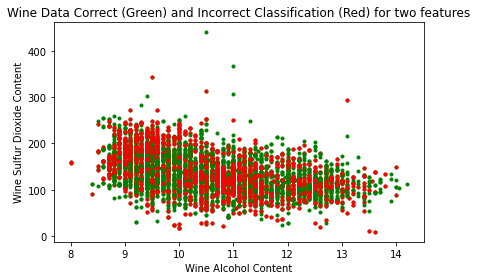

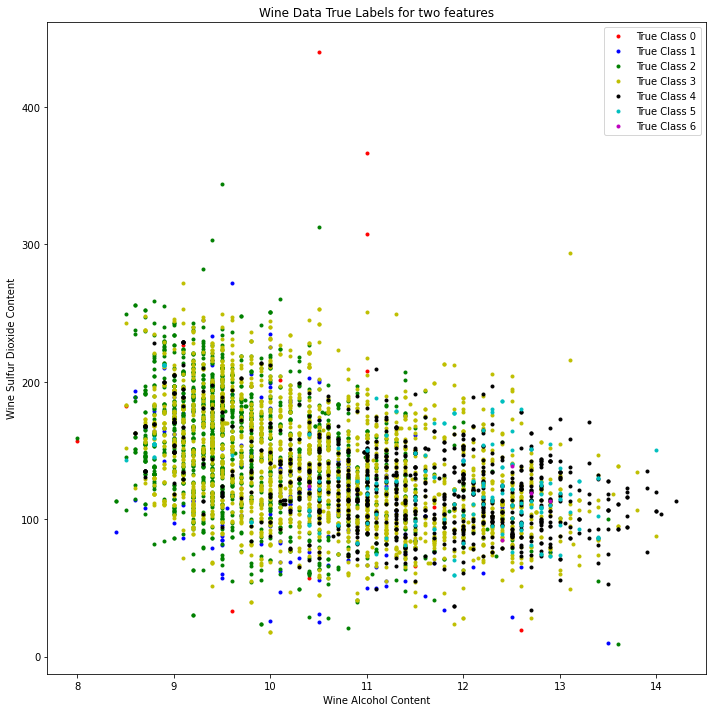

(4898, 11)
(4898, 11)


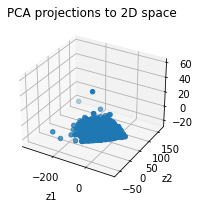

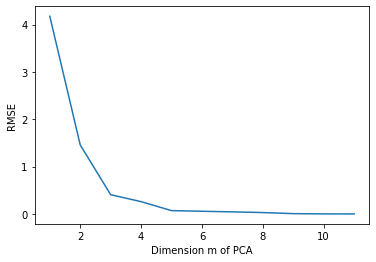

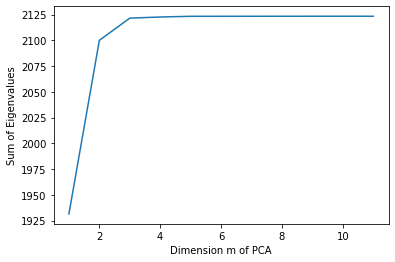

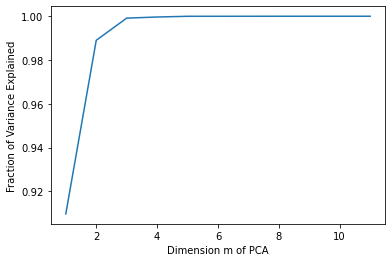

In [5]:
# fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
winedata = np.array(read_csv('winequality-white.csv', sep = ';'))

# labels 0 - 3 are empty, remove them from the list
winedata[:,-1] = np.array([winedata[i,-1] -3 for i in range(winedata.shape[0])])
labels = winedata[:,-1] # take provided labels from last column of dataset

valid_classes = np.array([0,1,2,3,4,5,6])
print("Valid Classes: ", valid_classes)

X = np.array(winedata[:,0:11])

erm_classifier(X,valid_classes,labels)
pca_work(X,valid_classes,labels)